In [1]:
from classiq import *

# Quantum Walks

Quantum walks has unique properties due to quantum superposition and interference unlike the classical counter part. 
The quantum walk is implemented on a linear topology where each node is connected to its immediate neighbors. The implementation utilizes a set of quantum operations to simulate the walk, involving state preparation, diffusion processes, and conditional transitions between nodes based on quantum state probabilities.

### Step 1: prepare an auxiliary qubit in the |-⟩ state to facilitate the diffusion process.

In [2]:
size = 4
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

### Step 2: Implement the oracle for the diffusion process, flipping the auxiliary qubit based on the state of the node.

In [3]:
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

### Step 3: Apply the diffusion process using the auxiliary qubit.

In [4]:
def zero_diffuzer(aux: QNum,x: QNum):
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

### Step 4: Define the walking and connectivity logic for transitioning between nodes.

In [5]:
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum, aux: QNum):
    prob = [0] * 16  # Now supporting 16 nodes
    if i > 0:
        prob[i - 1] = 0.5  # Connect to the previous node
    if i < 15:
        prob[i + 1] = 0.5  # Connect to the next node
    if i == 0:
        prob[i+1] = 1
    if i == 15:
        prob[i-1] = 1
        
    print(f'State={i}, prob vec={prob}')

    control(ctrl=vertices == i,
            operand=lambda: within_apply(
                compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action=lambda: zero_diffuzer(aux, adjacent_vertices)))

@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    for i in range(2**size):
        W_iteration(i,vertices,adjacent_vertices,aux)

### Step 5: Apply a bitwise swap between the quantum states of adjacent nodes, effectively allowing the quantum walker to move along the graph.

In [6]:
@qfunc
def edge_oracle(res:Output[QNum], vertices: QNum, adjacent_vertices: QNum):
    res |= ((vertices-adjacent_vertices) ==1) | ((adjacent_vertices-vertices) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
        iteration= lambda i: SWAP(x[i],y[i]))

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res1 = QNum('res1')
    edge_oracle(res1,vertices,adjacent_vertices)
    control(ctrl= res1==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

### Step 6: Visualize the model in Main function

In [7]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

    allocate(size,vertices)
    hadamard_transform(vertices)
    allocate(size,adjacent_vertices)


    W_operator(vertices,adjacent_vertices)
    S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qmod_with_constraints = set_constraints(
    qmod, Constraints(optimization_parameter="width", max_depth=2000)
)
qprog = synthesize(qmod_with_constraints)
show(qprog)
results = execute(qprog).result()

State=0, prob vec=[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec=[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec=[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec=[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec=[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec=[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec=[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec=[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec=[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
State=

### Synthesized model from Classiq Platform

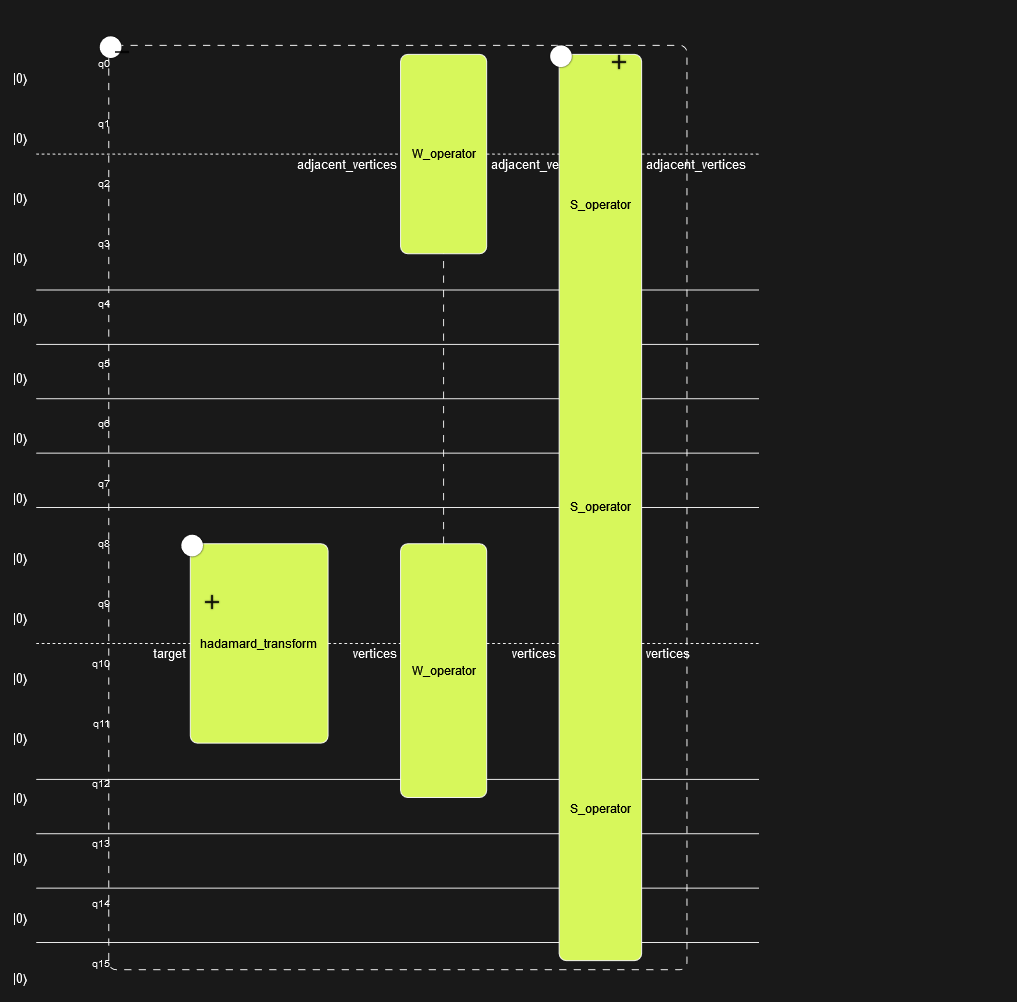

In [10]:
from IPython.display import Image
Image(filename='classiq.png')